In [35]:
import os
import numpy as np
import glob
import shutil
import matplotlib.pyplot as plt
from PIL import Image
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
from mpl_toolkits.mplot3d import Axes3D

In [36]:
# Create directory to store plots.
if not os.path.exists('./img'):
    os.makedirs('./img')

In [37]:
# List to store the best historical values used for plotting.
global_historic = []
personal_mean_historic = []

In [38]:
class PSO:
    '''
    Class used to design the Particle Swarm Optimization.
    '''
    def __init__(self, particles, velocities, fitness_function, c_1=1, c_2=1, max_iter=1000):
        # Pass the particles positions and velocities.
        self.particles = particles
        self.velocities = velocities
        # Pass the fitness function that will be used to get best values.
        self.fitness_function = fitness_function

        # Pass the constants.
        self.N = len(self.particles)
        self.c_1 = c_1
        self.c_2 = c_2
        self.max_iter = max_iter

        # Initialize the best personal and global values.
        self.p_bests = self.particles
        self.p_bests_values = self.fitness_function(self.particles)

        # Since the particles are in random places just get the best at the first particle.
        self.g_best = self.p_bests[0]
        self.g_best_value = self.p_bests_values[0]
        self.update_bests()

        self.iter = 0

    def next(self):
        ''' 
        Function that does the iteration.
        '''
        if self.iter > 0:
            self.move_particles()
            self.update_bests()
        self.iter += 1
        # Stop the iteration when reached max number of iter.
        self.is_running = self.iter < self.max_iter
        return self.is_running

    def move_particles(self):
        ''' 
        Function that computes the new speed and then updates the positions according to the new speed.
        '''
        # Allocate new velocities np array.
        new_velocities = self.velocities
        # Add cognitive (personal) component to speed.
        r_1 = np.random.random(self.N)
        # Tile is used to get from a random to an array of randoms.
        r_1 = np.tile(r_1[:, None], (1, 2))
        new_velocities += self.c_1 * r_1 * (self.p_bests - self.particles)
        # Add social (global) component to speed.
        r_2 = np.random.random(self.N)
        r_2 = np.tile(r_2[:, None], (1, 2))
        g_best = np.tile(self.g_best[None], (self.N, 1))
        new_velocities += self.c_2 * r_2 * (g_best  - self.particles)

        # Update the new velocities by a normalized vector, then update positions.
        new_velocities = new_velocities / np.linalg.norm(new_velocities)
        self.velocities = new_velocities
        self.particles = self.particles + new_velocities

    def __str__(self):
        ''' 
        String definition because is used to get the title of the graph in the GIF. 
        '''
        return f'[{self.iter}/{self.max_iter}] - $c_1$:{self.c_1:.3f} - $c_2$:{self.c_2:.3f}'

    def update_bests(self):
        ''' 
        Function that update the personal best for each particle and also the global best for the swarm.
        '''
        # Compute fitness (aka Ackley).
        fits = self.fitness_function(self.particles)
        for i in range(len(self.particles)):
            # update best personnal value (cognitive)
            if fits[i] < self.p_bests_values[i]:
                self.p_bests_values[i] = fits[i]
                self.p_bests[i] = self.particles[i]
                # update best global value (social)
                if fits[i] < self.g_best_value:
                    self.g_best_value = fits[i]
                    self.g_best = self.particles[i]
        # Add to the historical.
        personal_mean_historic.append(np.mean(self.p_bests_values))
        global_historic.append(self.g_best_value)

In [39]:
def make_gif_from_folder(folder, out_file_path, remove_folder=True):
    ''' Function used to create a gif, given a folder of png images numbered sequentially. '''
    files = os.path.join(folder, '*.png')
    img, *imgs = [Image.open(f) for f in sorted(glob.glob(files))]
    img.save(fp=out_file_path, format='GIF', append_images=imgs,
             save_all=True, duration=200, loop=0)
    shutil.rmtree(folder, ignore_errors=True)

In [40]:
# Give parameters for plotting.
plt.rcParams['figure.figsize'] = [12, 6] # default = [6.0, 4.0]
plt.rcParams['figure.dpi']     = 100     # default = 72.0
plt.rcParams['font.size']      = 7.5     # default = 10.0

In [41]:
# Plotting coloring map.
cmap = cm.colors.LinearSegmentedColormap.from_list('Custom',
                                                   [(0, '#2f9599'),
                                                    (0.45, '#eeeeee'),
                                                    (1, '#8800ff')], N=256)

In [42]:
def plot_2d_pso(meshgrid, function, particles=None, velocity=None, normalize=True, color='#000000', ax=None):
    ''' Functions that plots the pso in a 2D way. '''
    X_grid, Y_grid = meshgrid
    # Get value of functions.
    Z_grid = function(X_grid, Y_grid)
    # Get coordinates and velocity arrays.
    if particles is not None:
        X, Y = particles.swapaxes(0, 1)
        Z = function(X, Y)
        if velocity is not None:
            U, V = velocity.swapaxes(0, 1)
            if normalize:
                N = np.sqrt(U**2+V**2)
                U, V = U/N, V/N

    # Create new ax if None
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1, projection='3d')

    # Add contours and contours lines.
    ax.contour(X_grid, Y_grid, Z_grid, levels=30, linewidths=0.5, colors='#999999')
    cntr = ax.contourf(X_grid, Y_grid, Z_grid, levels=30, cmap=cmap, alpha=0.7)
    if particles is not None:
        ax.scatter(X, Y, color=color)
        if velocity is not None:
            ax.quiver(X, Y, U, V, color=color, headwidth=2, headlength=2, width=5e-3)

    # Add labels and set equal aspect ratio.
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_xlim(np.min(X_grid), np.max(X_grid))
    ax.set_ylim(np.min(Y_grid), np.max(Y_grid))
    ax.set_aspect(aspect='equal')


In [43]:
def plot_3d_pso(meshgrid, function, particles=None, velocity=None, normalize=True, color='#000000', ax=None):
    ''' Functions that plots the pso in a 3D way. '''
    X_grid, Y_grid = meshgrid
    Z_grid = function(X_grid, Y_grid)
    # Get coordinates and velocity arrays.
    if particles is not None:
        X, Y = particles.swapaxes(0, 1)
        Z = function(X, Y)
        if velocity is not None:
            U, V = velocity.swapaxes(0, 1)
            W = function(X + U, Y + V) - Z

    # Create new ax if None.
    if ax is None:
        fig = plt.figure()
        ax = fig.add_subplot(1, 1, 1, projection='3d')

    # Plot the surface.
    surf = ax.plot_surface(X_grid, Y_grid, Z_grid, cmap=cmap,
                           linewidth=0, antialiased=True, alpha=0.7)
    ax.contour(X_grid, Y_grid, Z_grid, zdir='z', offset=0, levels=30, cmap=cmap)
    if particles is not None:
        ax.scatter(X, Y, Z, color=color, depthshade=True)
        if velocity is not None:
            ax.quiver(X, Y, Z, U, V, W, color=color, arrow_length_ratio=0., normalize=normalize)

    len_space = 10
    # Customize the axis.
    max_z = (np.max(Z_grid) // len_space + 1).astype(np.int) * len_space
    ax.set_xlim3d(np.min(X_grid), np.max(X_grid))
    ax.set_ylim3d(np.min(Y_grid), np.max(Y_grid))
    ax.set_zlim3d(0, max_z)
    ax.zaxis.set_major_locator(LinearLocator(max_z // len_space + 1))
    ax.zaxis.set_major_formatter(FormatStrFormatter('%.0f'))
    
    # Remove fills and set labels.
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('f(X, Y)')

In [44]:
# Number of particles of the swarm.
n_particles = 50

# Make range grid.
X = np.arange(-32.786, 32.786, 0.05)
Y = np.arange(-32.786, 32.786, 0.05)
meshgrid = np.meshgrid(X, Y)

In [45]:
def ackley(x, y, a=20, b=0.2, c=2*np.pi):
    ''' Definition of the ackley function given two arrays of x and y values. '''
    return -a * np.exp(-b * np.sqrt(x*x + y*y)/2) - np.exp(1/2 * (np.cos(c*x) + np.cos(c*y))) + a + np.exp(1)

In [46]:
def fitness_function(pos):
    ''' Helper function that splits x and y. '''
    x, y = pos.swapaxes(0, 1)
    return ackley(x, y)

In [47]:
# Allocate random particles and give random velocities.
particles = np.random.uniform(-32.786, 32.786, (n_particles, 2))
velocities = (np.random.random((n_particles, 2)) - 0.5) / 10

# Create the PSO solver.
pso_1 = PSO(particles.copy(), velocities.copy(), fitness_function, c_1=2.0, c_2=2.0)

In [48]:
# Stuff needed to create the animation of the plot.
root = 'src/'
filename = '_tmp.gif'
save = True

if save:
    tmp_dir = os.path.join(root, '_tmp')
    if not os.path.exists(tmp_dir):
        os.makedirs(tmp_dir)

fig = plt.figure()

# Iterate until the max iteration number is reached.
while pso_1.next():
    # Clear the plot.
    fig.clear()
    save_path = None if not save else os.path.join(tmp_dir, f'{pso_1.iter:05d}.png')
    if pso_1.iter % 50 == 0:
        print(pso_1.iter)
    if pso_1.iter < 200:
        # Add 2d and 3d subplots.
        ax = fig.add_subplot(1, 3, 1)
        plot_2d_pso(meshgrid, ackley, pso_1.particles, pso_1.velocities, ax=ax)
        ax.set_title('2D plot of PSO along ackley function')
        ax = fig.add_subplot(1, 2, 2, projection='3d')
        plot_3d_pso(meshgrid, ackley, pso_1.particles, pso_1.velocities, ax=ax)
        ax.set_title('3D plot of PSO along ackley function')
        # Title of the function contains iterations and constant values.
        fig.suptitle(str(pso_1))

        if save_path is None:
            plt.show()
        else:
            plt.savefig(save_path)

# Create the gif from the folder and erase the folder.
make_gif_from_folder(tmp_dir, os.path.join(root, filename))

/home/jamirl/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:29: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950


<Figure size 1200x600 with 0 Axes>

In [49]:
def plot_curve(evaluated, name, filename):
    '''
    Function to generate a plot for the best value found on each iteration.
    '''
    plt.figure(figsize=(16, 16))
    plt.title(name)
    plt.xlabel('Iteration', fontsize=18)
    plt.ylabel('Value of Ackley function', fontsize=16)
    plt.plot(evaluated)
    plt.savefig('./img/{}.png'.format(filename))
    plt.show()

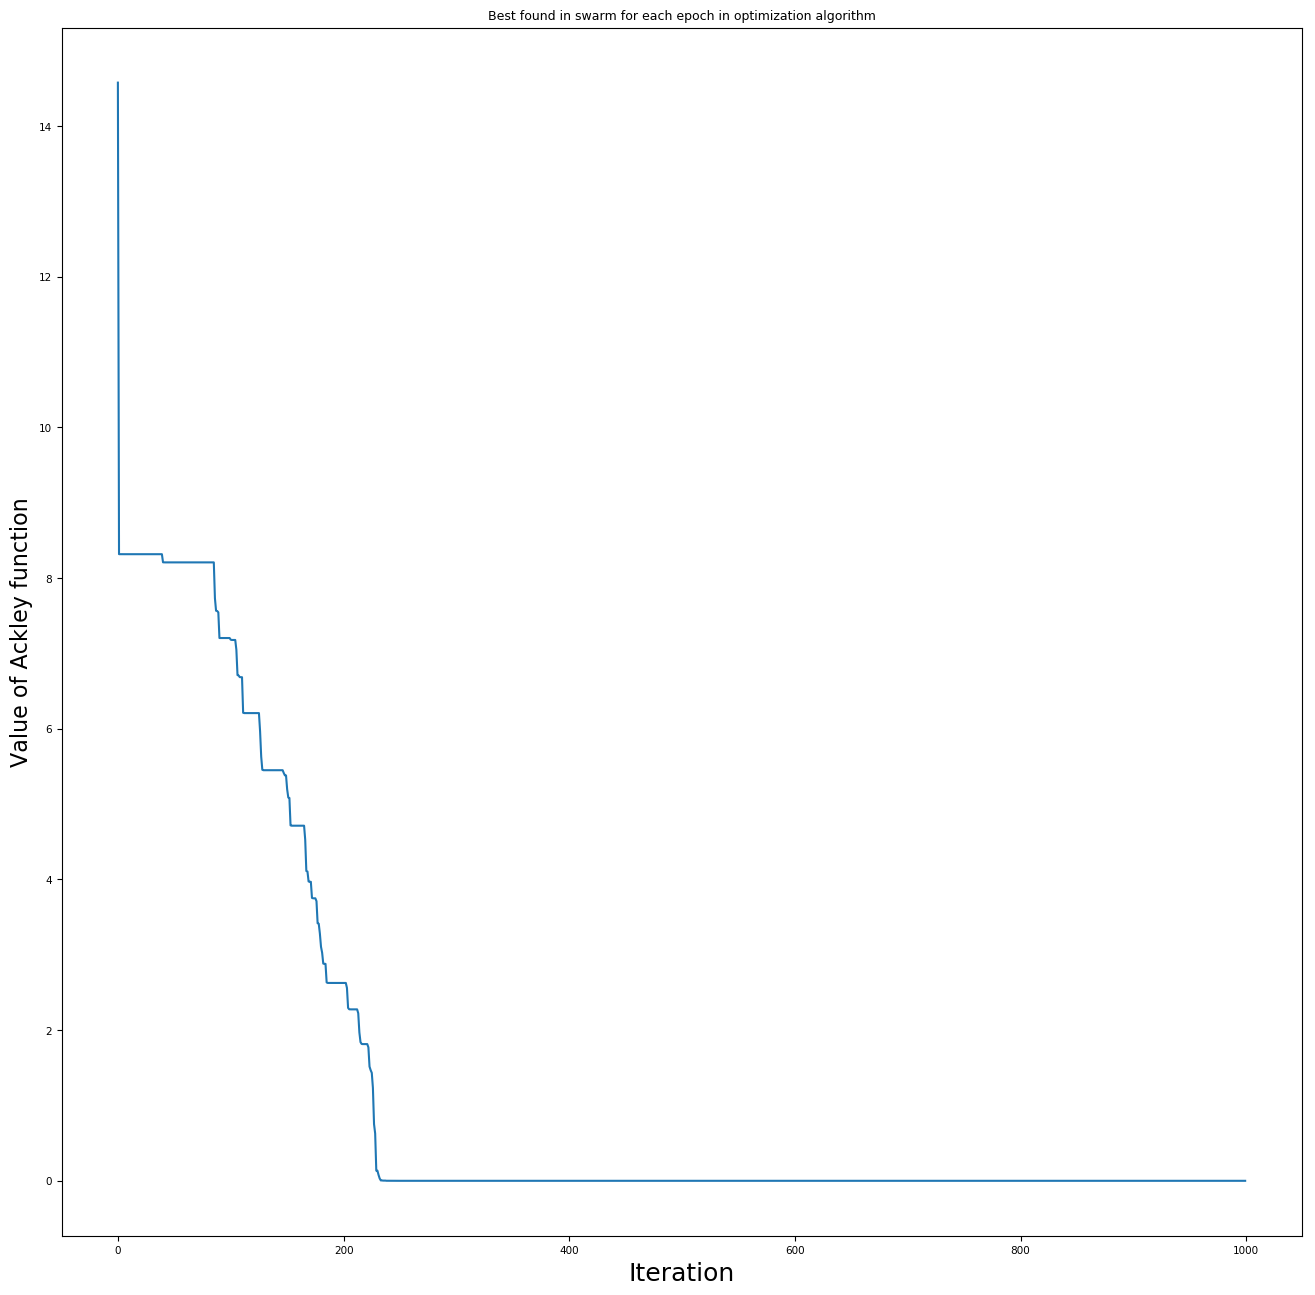

In [50]:
plot_curve(global_historic, 'Best found in swarm for each epoch in optimization algorithm', 'global_historic')

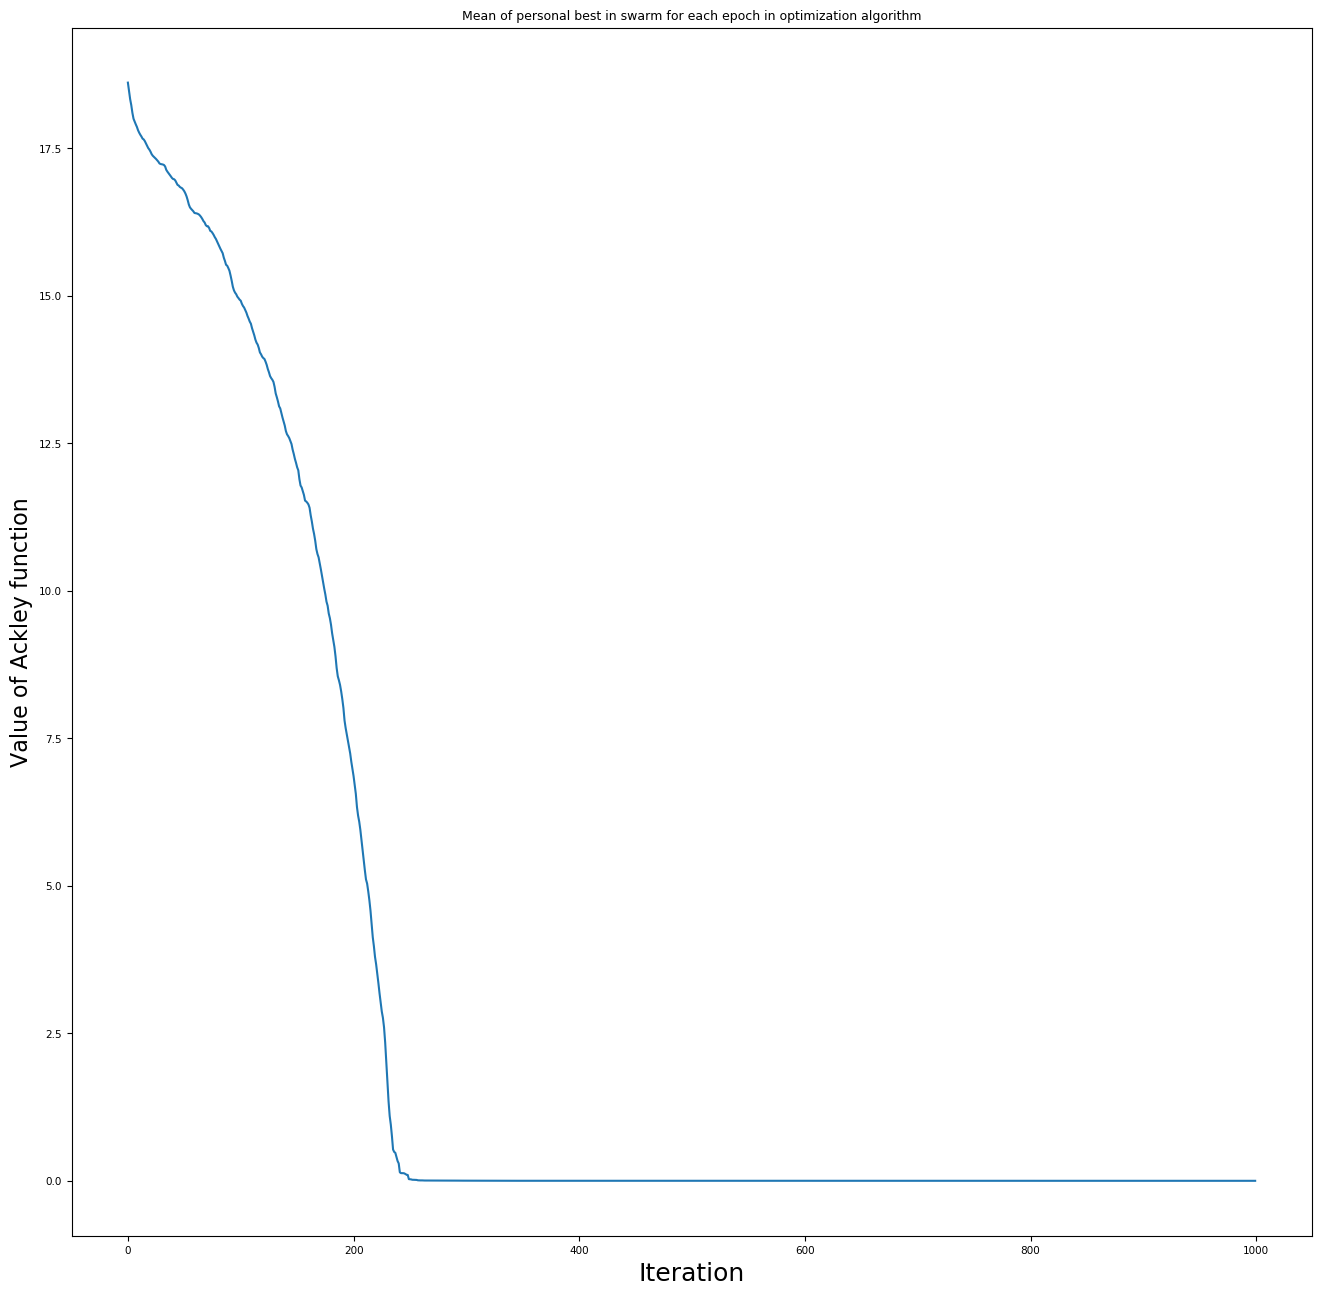

In [51]:
plot_curve(personal_mean_historic, 'Mean of personal best in swarm for each epoch in optimization algorithm', 'personal_mean_historic')